In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from src.n_forest import alpha

In [2]:
def deriv_forest(x, y, penalty_rate, args):
    """
    Calculate derivatives of x and y over time as per the Antonovsky & Korzukhin rule.
    
    INPUT:
    x            = value for x; density of young trees in ecosystem, typically between 0 and 4
    y            = value for y; density of old trees in ecosystem, typically between 0 and 4
    penalty_rate = penalty rate calculated by penalty function
    args         = tuple of 9 arguments

    Returns derivatives of x and y.
    """
    # Unpack arguments rho, gamma (not used), f, h, a1 and a2
    fertility, aging_rate, biotic_pump_young, mortality_old, biotic_pump_old, dist, beta_2, P_0 = args
    
    # Calculate derivatives
    dx = fertility * y - ((y - 1)**2 + 1) * x - aging_rate * x + biotic_pump_young * penalty_rate * x
    dy = aging_rate * x - mortality_old * y + biotic_pump_old * penalty_rate * y
    
    return dx, dy

In [3]:
def deriv_forest_for_solveivp(t, u, fertility, aging_rate, 
                            biotic_pump_young, mortality_old, biotic_pump_old, dist, beta_2, P_0, x0s, y0s, i):
    """
    Calculate derivatives of x and y over time as per the Antonovsky & Korzukhin rule with the penalty function included, 
    
    INPUT:
    x            = value for x; density of young trees in ecosystem, typically between 0 and 4
    y            = value for y; density of old trees in ecosystem, typically between 0 and 4
    penalty_rate = penalty rate calculated by penalty function
    the args above here are given seperately, as solve ivp unpacks its arguments already

    Returns derivatives of x and y.
    """
    # Unpack arguments rho, gamma (not used), f, h, a1 and a2
    #fertility, aging_rate, biotic_pump_young, mortality_old, biotic_pump_old, x0s, y0s, i = args
    x, y = u
    dist = dist / (len(x0s) -1)
    penalty_rate = alpha(x0s, y0s, dist, beta_2 = beta_2, P_0 = P_0)
    
    # Calculate derivatives
    dx = fertility * y - ((y - 1)**2 + 1) * x - aging_rate * x + biotic_pump_young * penalty_rate[i] * x
    dy = aging_rate * x - mortality_old * y + biotic_pump_old * penalty_rate[i] * y
    
    return (dx, dy)

In [5]:
def system_n_forests_solveivp(x0s, y0s, args, timesteps = 100, dt = 0.01):
    """
    Solves a system of ODEs
    INPUT:
    x0s       = array of values for x, the density of young trees in the ecosystem; typically between 0 and 4
    y0s       = array of values for y, the density of old trees in the ecosystem; typically between 0 and 4
    args      = tuple of arguments needed for the derivation function
    timesteps = int, timesteps to iterate over; default 100
    dt        = delta time, default 0.01
    
    Returns two arrays of x and y values per time
    """
    assert (isinstance(args, (tuple, list, np.ndarray))), "Your args variable should be a list-like."
    assert (len(args)== 8), ("Make sure you have all arguments needed included: fertility, aging_rate, biotic_pump_young,"
                          "mortality_old, biotic_pump_old, dist, beta_2, P_0.")
    assert len(x0s) == len(y0s), "The input vector for the young and old trees should be the same length."
    n = len(x0s)
    x_vals = np.empty((n, int(timesteps/dt)))
    y_vals = np.empty((n, int(timesteps/dt)))
    
    args = [*args, x0s, y0s, 0]
    for i in range(n):
        args[-1] = i 
        res = solve_ivp(deriv_forest_for_solveivp, [0, timesteps], [x0s[i], y0s[i]], t_eval = np.arange(0, timesteps, dt), 
                        args = (args))
        x_vals[i, :] = res.y[0]
        y_vals[i, :] = res.y[1]
            
    return res.t, x_vals, y_vals


In [7]:
def system_n_forests_forward(x0s, y0s, args, timesteps = 100, dt = 0.01):
    """Solve the system of ODEs of the Antonovosky rule using forward euler.

    Args:
        x0s: array of values for x, the density of young trees in the ecosystem; 
            typically between 0 and 4.
        y0s: array of values for y, the density of old trees in the ecosystem; 
            typically between 0 and 4.
        args: tuple of arguments needed for the derivation function
        timesteps: int, timesteps to iterate over; default 100
        dt: Delta time, default 0.01
    
    Returns:
        Two arrays of x and y values per time
    """
       
    assert (isinstance(args, (tuple, list, np.ndarray))),( 
            "Your args variable should be a list-like.")
    assert (len(args)== 8), ("Make sure you have all arguments needed included:"
                             " fertility, aging_rate,"
                             "biotic_pump_young,"
                             "mortality_old, biotic_pump_old, dist, beta_2, P_0.")
    assert len(x0s) == len(y0s), ("The input vector for the young and old trees" 
                                   "should be the same length.")
    
    n = len(x0s)
    x_vals = np.empty((n, int(timesteps/dt)))
    y_vals = np.empty((n, int(timesteps/dt)))

    for t in range(int(timesteps / dt)):
        penalties = alpha(x0s, y0s, dist=args[5]/(n-1), beta_2 = args[6],
                          P_0 = args[7])
        for i in range(n):
            
            x_vals[i, t] = x0s[i]
            y_vals[i, t] = y0s[i]
            
            dx, dy = deriv_forest(x0s[i], y0s[i], penalties[i], args)
            x0s[i] += dx * dt
            y0s[i] += dy * dt            
            
    return x_vals, y_vals


Trying to remake figure 8

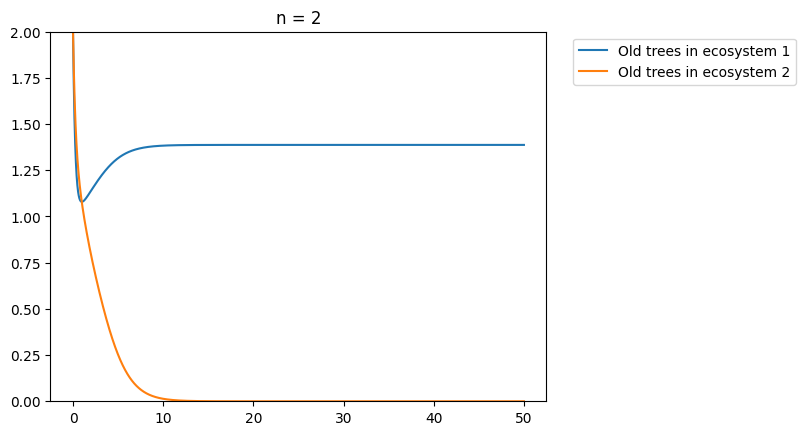

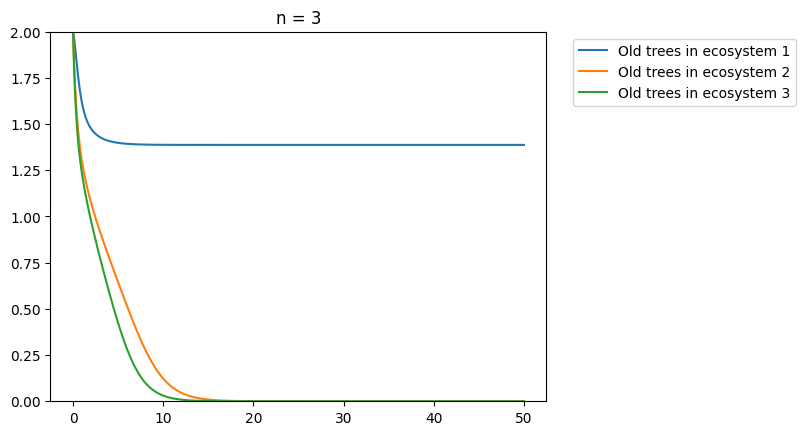

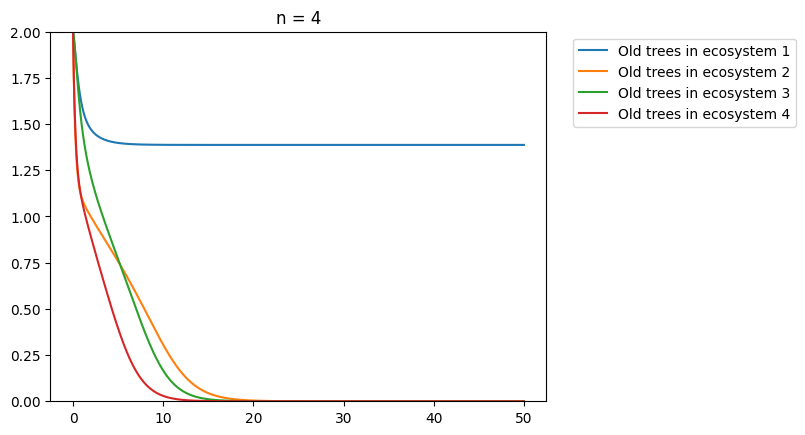

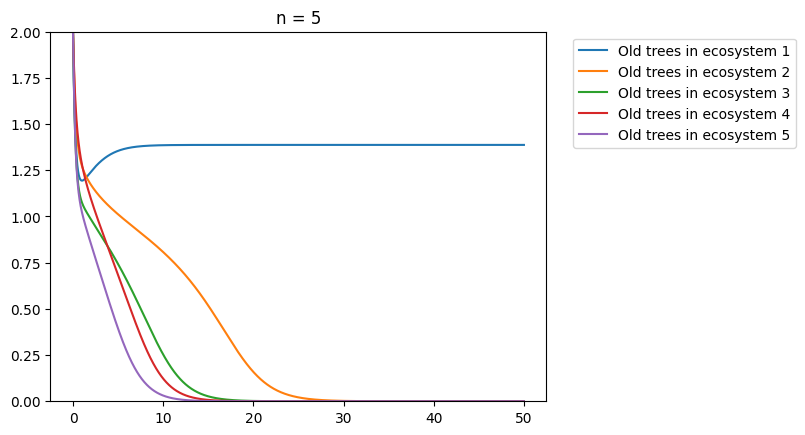

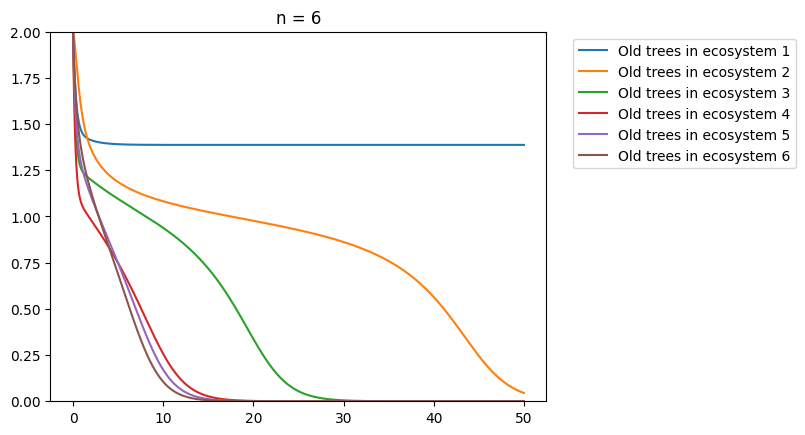

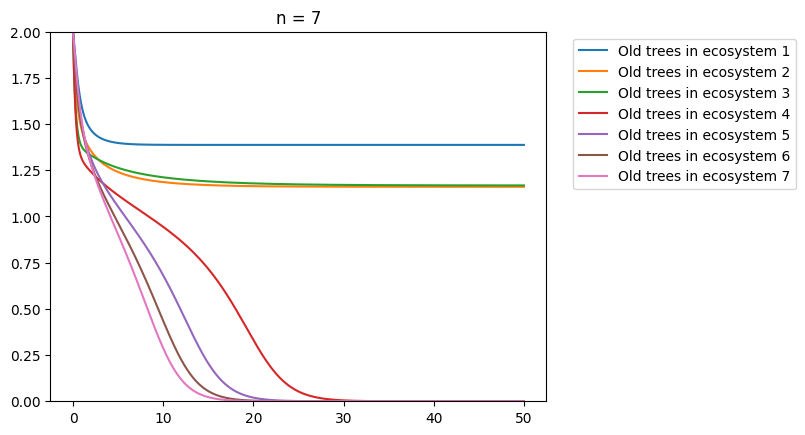

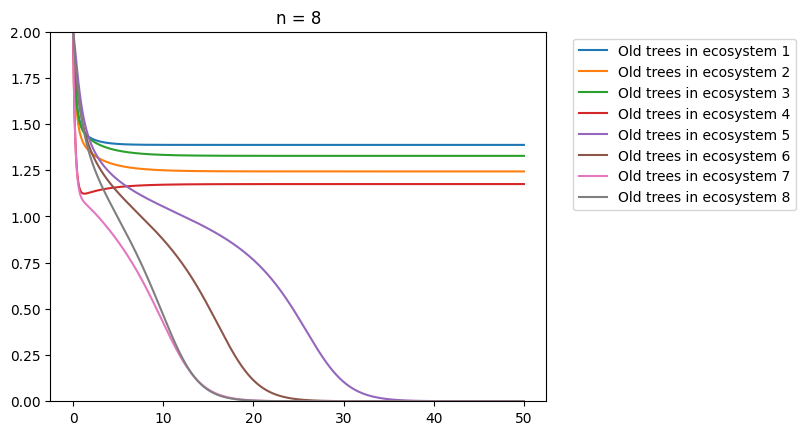

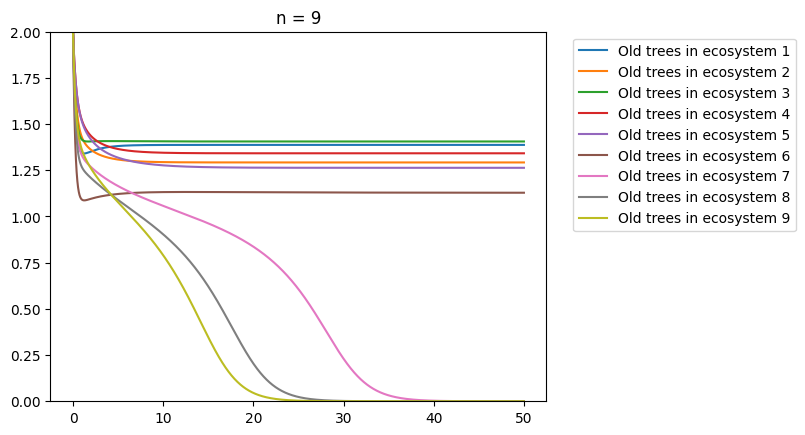

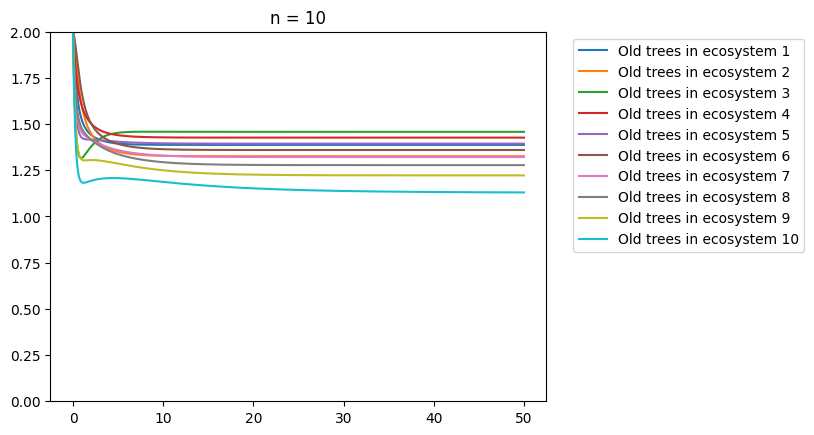

In [8]:
fertility = 4.2 #rho
aging_rate = 1 #f
biotic_pump_young = 1 #a1
mortality_old = 2 #h
biotic_pump_old = 0 #a2
dist = 900
beta_2 = 0.1
P_0 = 1.05

arguments = (fertility, aging_rate, biotic_pump_young, mortality_old, biotic_pump_old, dist, beta_2, P_0)
time = 50
dt = 0.01

for n in range(2, 11):
    xs, ys = system_n_forests_forward(np.random.uniform(0,4,n),np.ones(n)*2, arguments, time, dt)

    for i, y in enumerate(ys):
        #plt.plot(t, x, label = f"Young trees in ecosystem {i+1}")
        plt.plot(np.arange(0, time, dt), y, label = f"Old trees in ecosystem {i+1}")
    plt.title(f"n = {n}")
    plt.ylim(0,2)
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.show()


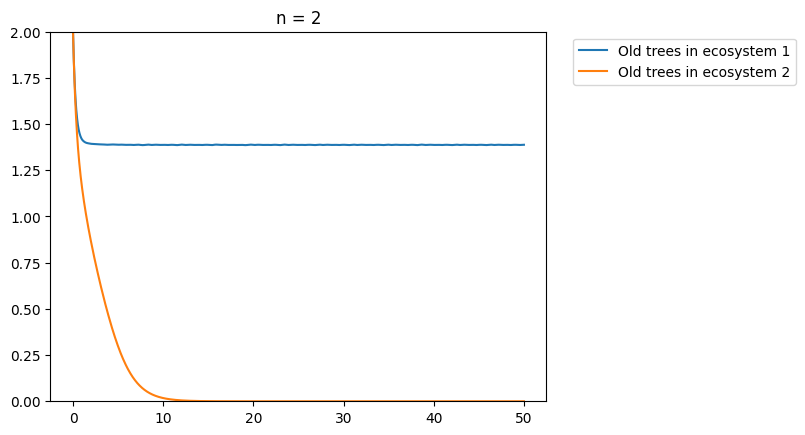

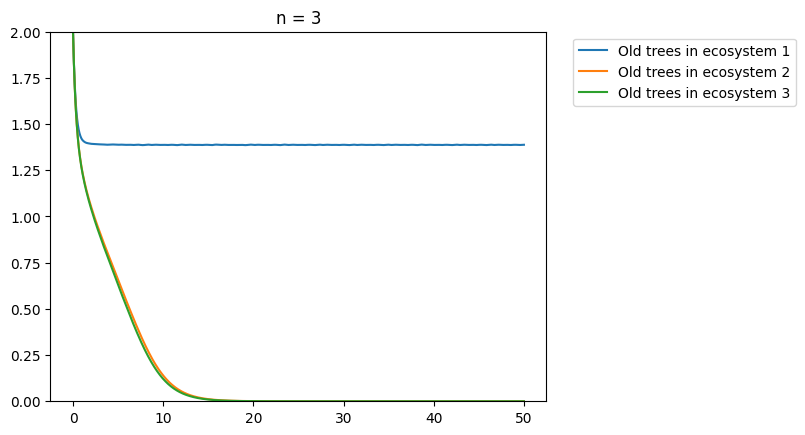

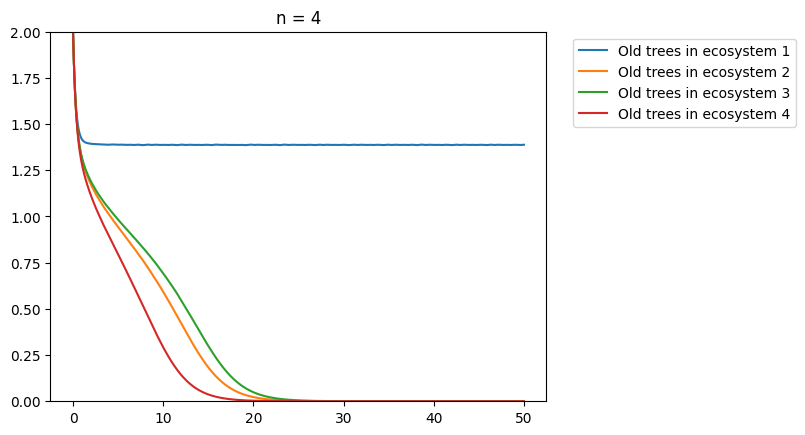

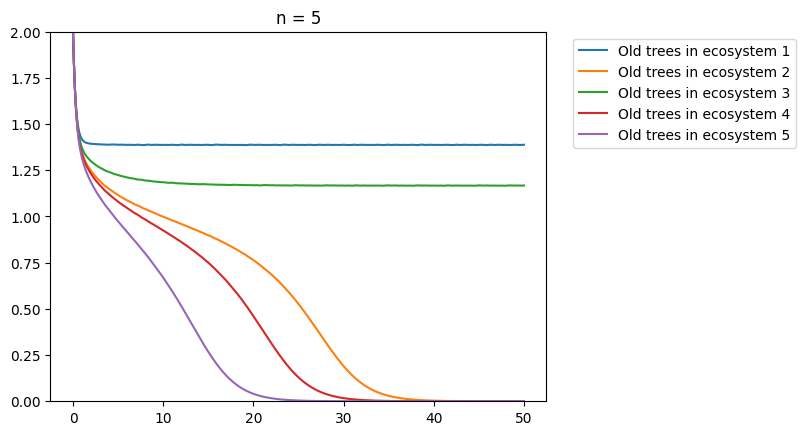

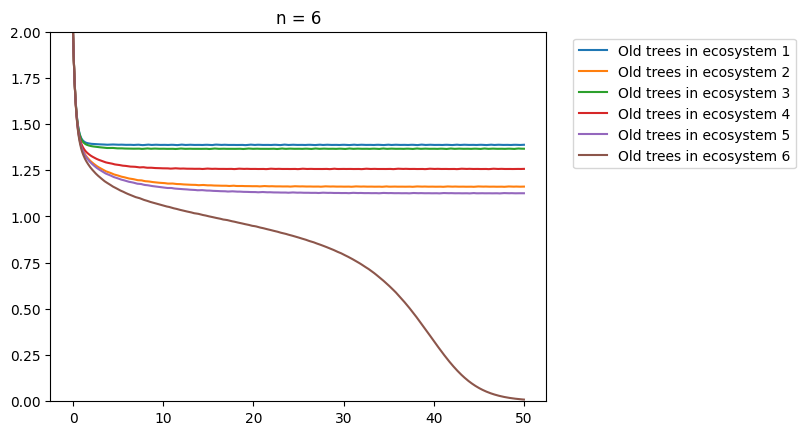

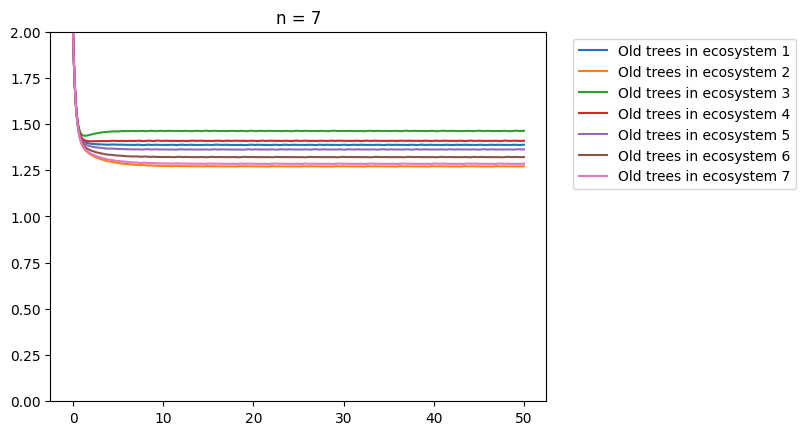

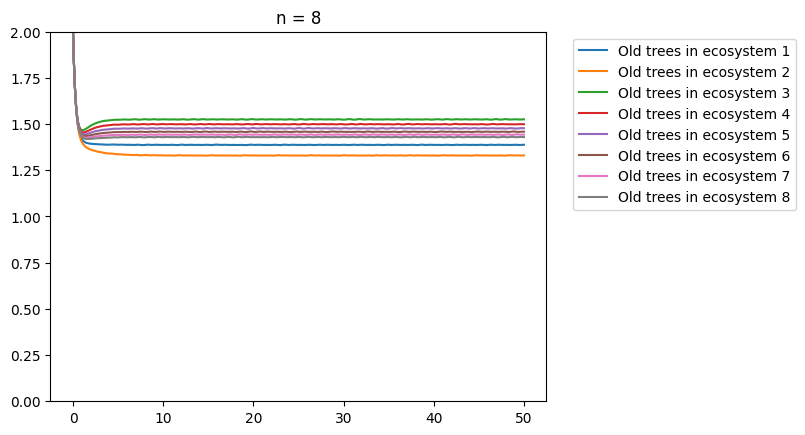

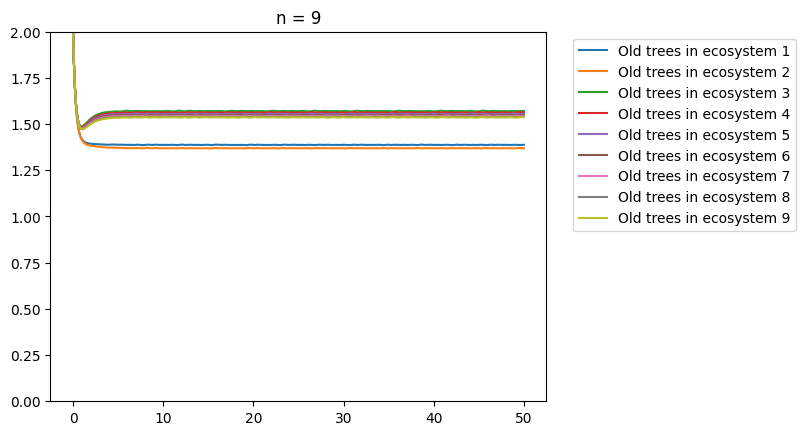

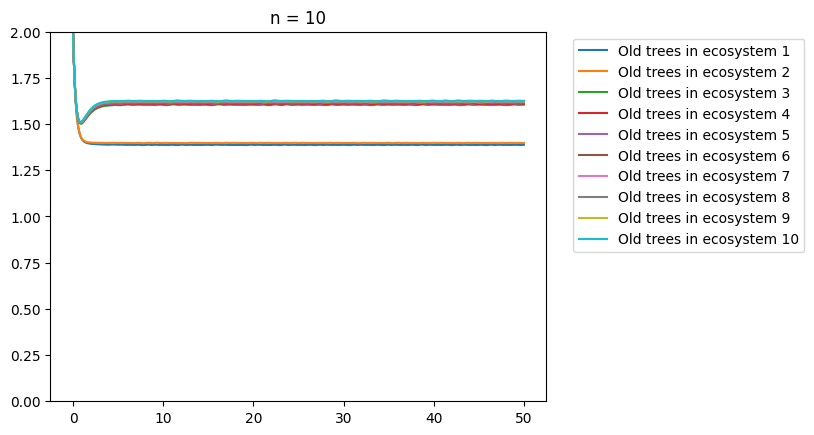

In [9]:
for n in range(2, 11):
    t, xs, ys = system_n_forests_solveivp(np.ones(n)*2,np.ones(n)*2, arguments, time, dt)
    for i, x in enumerate(xs):
        plt.plot(t, ys[i], label = f"Old trees in ecosystem {i+1}")
    plt.title(f"n = {n}")
    plt.ylim(0,2)
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.show()